In [18]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

warnings.filterwarnings('ignore')

import data_preprocessing
import context_handlers
import vit_pipeline
import EDCR_pipeline


############################################################################################################
##################################################vit_l_16##################################################
############################################################################################################


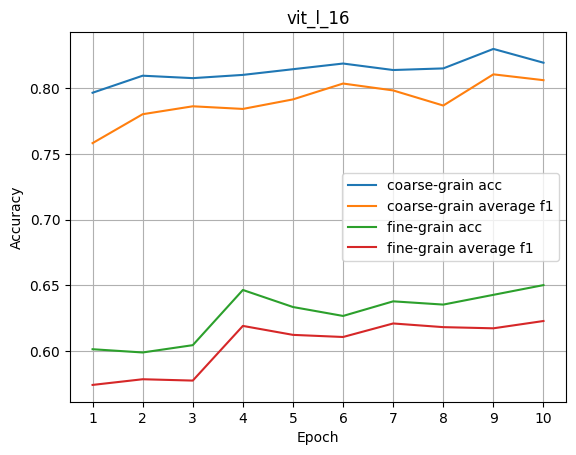

<Figure size 640x480 with 0 Axes>

In [19]:
results_dir = 'results/'

test_data = {}
test_fine_true = np.load(os.path.join(results_dir, f'test_fine_true.npy'))
test_coarse_true = np.load(os.path.join(results_dir, f'test_coarse_true.npy'))

for filename in os.listdir(results_dir):
    test_match = re.match(pattern=rf'(.+?)_test_(.+?)_pred_lr(.+?)_e(\d+?).npy',
                               string=filename)
    if test_match:
        model_name = test_match.group(1)
        granularity = test_match.group(2)
        lr_value = float(test_match.group(3))
        num_epochs = int(test_match.group(4)) + 1
    
        test_pred = np.load(os.path.join(results_dir, filename))
        classes = data_preprocessing.get_classes(granularity=granularity)
        n_classes = len(classes)
        test_true = test_fine_true if granularity == 'fine' else test_coarse_true
    
        if model_name not in test_data:
            test_data[model_name] = {}
        if granularity not in test_data[model_name]:
            test_data[model_name][granularity] = {}
        if lr_value not in test_data[model_name][granularity]:
            test_data[model_name][granularity][lr_value] = {}
    
        test_data[model_name][granularity][lr_value][num_epochs] = \
            {'acc': accuracy_score(y_true=test_true, y_pred=test_pred), 
             'cm': confusion_matrix(y_true=test_true, y_pred=test_pred),
             'pre': precision_score(y_true=test_true, y_pred=test_pred, labels=range(n_classes), average='macro'),
             'rec': recall_score(y_true=test_true, y_pred=test_pred, labels=range(n_classes), average='macro'),
             'f1': f1_score(y_true=test_true, y_pred=test_pred, labels=range(n_classes), average='macro')}
                
def plot_verbose_test_metrics():
    for model_name, model_data in sorted(test_data.items()):
        print('\n' + '#'* (100 + len(model_name)))
        print('#'* 50 + f'{model_name}' + '#'* 50)
        print('#'* (100 + len(model_name)) + '\n')
        metric = 'Accuracy'
        
        with context_handlers.Plot():
            plt.title(f"{model_name}")
            plt.xlabel('Epoch')
            plt.ylabel(metric)
            
            for granularity, granularity_data in sorted(model_data.items()):
                for lr_value, lr_data in sorted(granularity_data.items()):
                    epochs, epoch_data = zip(*sorted(lr_data.items()))
                    plt.plot(epochs, [curr_data['acc'] for curr_data in epoch_data], label=f'{granularity}-grain acc')
                    plt.plot(epochs, [curr_data['f1'] for curr_data in epoch_data], label=f'{granularity}-grain average f1')
                    plt.xticks(np.arange(min(epochs), max(epochs)+1, 1)) # Set the x-axis ticks to be integers
        
            plt.legend()
            plt.grid()

plot_verbose_test_metrics()

# Prior

In [20]:
main_model_name = 'vit_l_16'
main_lr = 0.0001
secondary_model_name = 'vit_l_16'
secondary_lr = 0.0001

prior_fine_path = f'{main_model_name}_test_fine_pred_lr{main_lr}_e{vit_pipeline.num_epochs - 1}_2.npy'
prior_coarse_path = f'{main_model_name}_test_coarse_pred_lr{main_lr}_e{vit_pipeline.num_epochs - 1}_2.npy'

prior_fine_data = np.load(os.path.join(vit_pipeline.results_path, prior_fine_path))
prior_coarse_data = np.load(os.path.join(vit_pipeline.results_path, prior_coarse_path))

true_fine_data = np.load(os.path.join(vit_pipeline.results_path, 'test_fine_true.npy'))
true_coarse_data = np.load(os.path.join(vit_pipeline.results_path, 'test_coarse_true.npy'))

prior_fine_acc = accuracy_score(y_true=true_fine_data, y_pred=prior_fine_data)
prior_fine_f1 = f1_score(y_true=true_fine_data, y_pred=prior_fine_data, labels=range(len(data_preprocessing.fine_grain_classes)), average='macro')
prior_coarse_acc = accuracy_score(y_true=true_coarse_data, y_pred=prior_coarse_data)
prior_coarse_f1 = f1_score(y_true=true_coarse_data, y_pred=prior_coarse_data, labels=range(len(data_preprocessing.coarse_grain_classes)), average='macro')

print(f'Prior fine accuracy: {round(prior_fine_acc * 100, 2)}%, '
      f'prior fine macro average f1: {round(prior_fine_f1 * 100, 2)}%\n'
      f'prior coarse accuracy: {round(prior_coarse_acc * 100, 2)}%, '
      f'prior coarse macro average f1: {round(prior_coarse_f1 * 100, 2)}%\n')

def get_num_inconsistencies(fine_predictions, coarse_predictions):
    inconsistencies = 0
    for fine_prediction, coarse_prediction in zip(fine_predictions, coarse_predictions):
        if data_preprocessing.fine_to_course_idx[fine_prediction] != coarse_prediction:
            inconsistencies += 1
    
    print(f'Total prior inconsistencies {inconsistencies}/{len(prior_fine_data)} which is {round(inconsistencies / len(prior_fine_data) * 100, 2)}%')

get_num_inconsistencies(fine_predictions=prior_fine_data, coarse_predictions=prior_coarse_data)

Prior fine accuracy: 61.44%, prior fine macro average f1: 59.52%
prior coarse accuracy: 79.46%, prior coarse macro average f1: 77.8%

Total prior inconsistencies 95/1621 which is 5.86%


# EDCR Results

In [21]:
fine_folder = (f'{EDCR_pipeline.figs_folder}/main_fine_{main_model_name}_lr{main_lr}'
                  f'_secondary_{secondary_model_name}_lr{secondary_lr}')
coarse_folder = (f'{EDCR_pipeline.figs_folder}/main_coarse_{main_model_name}_lr{main_lr}'
                  f'_secondary_{secondary_model_name}_lr{secondary_lr}')

post_fine_path = f'{fine_folder}/results.npy'
post_coarse_path = f'{coarse_folder}/results.npy'

post_fine_data = np.load(post_fine_path)
post_coarse_data = np.load(post_coarse_path)

post_fine_acc = accuracy_score(y_true=true_fine_data, y_pred=post_fine_data)
post_fine_f1 = f1_score(y_true=true_fine_data, y_pred=post_fine_data, labels=range(len(data_preprocessing.fine_grain_classes)), average='macro')
post_coarse_acc = accuracy_score(y_true=true_coarse_data, y_pred=post_coarse_data)
post_coarse_f1 = f1_score(y_true=true_coarse_data, y_pred=post_coarse_data, labels=range(len(data_preprocessing.coarse_grain_classes)), average='macro')

print(f'Post fine accuracy: {round(post_fine_acc * 100, 2)}%, '
      f'post fine macro average f1: {round(post_fine_f1 * 100, 2)}%\n'
      f'post coarse accuracy: {round(post_coarse_acc * 100, 2)}%, '
      f'post coarse macro average f1: {round(post_coarse_f1 * 100, 2)}%\n')

post_inconsistencies = get_num_inconsistencies(fine_predictions=post_fine_data, coarse_predictions=post_coarse_data)
post_inconsistencies

Post fine accuracy: 65.52%, post fine macro average f1: 63.2%
post coarse accuracy: 81.74%, post coarse macro average f1: 80.39%

Total prior inconsistencies 131/1621 which is 8.08%
